<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# KNN Classification and Imputation: Cell Phone Churn Data

_Authors: Kiefer Katovich (SF)_

---

In this lab you will practice using KNN for classification (and a little bit for regression as well).

The dataset is one on "churn" in cell phone plans. It has information on the usage of the phones by different account holders and whether or not they churned or not.

Our goal is to predict whether a user will churn or not based on the other features.

We will also be using the KNN model to **impute** missing data. There are a couple of columns in the dataset with missing values, and we can build KNN models to predict what those missing values will most likely be. This is a more advanced imputation method than just filling in the mean or median.

In [97]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.neighbors import KNeighborsClassifier

### 1. Load the cell phone "churn" data containing some missing values.

In [98]:
churn = pd.read_csv('./datasets/churn_missing.csv')

### 2. Examine the data. What columns have missing values?

In [99]:
# A:
churn.head(3)

,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,churn
0,KS,128,415,no,yes,25.0,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,no,yes,26.0,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,no,no,0.0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False


In [100]:
churn.isnull().sum()

state               0
account_length      0
area_code           0
intl_plan           0
vmail_plan        400
vmail_message     400
day_mins            0
day_calls           0
day_charge          0
eve_mins            0
eve_calls           0
eve_charge          0
night_mins          0
night_calls         0
night_charge        0
intl_mins           0
intl_calls          0
intl_charge         0
custserv_calls      0
churn               0
dtype: int64

In [5]:
churn.shape

(3333, 20)

In [6]:
churn.churn.sum()

483

In [7]:
churn.intl_plan.value_counts()

no     3010
yes     323
Name: intl_plan, dtype: int64

In [101]:
churn.vmail_plan.value_counts(dropna=False)

no     2130
yes     803
NaN     400
Name: vmail_plan, dtype: int64

In [102]:
sum(churn[churn.vmail_plan.isnull()].index == churn[churn.vmail_message.isnull()].index)

400

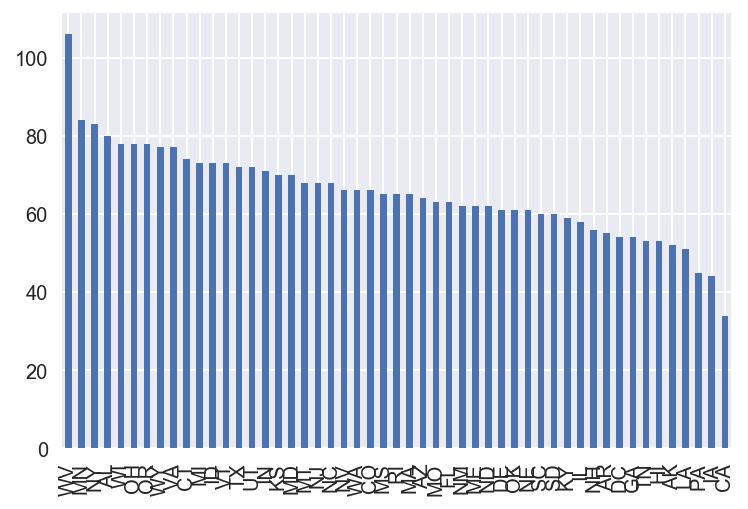

In [10]:
churn.state.value_counts().plot(kind='bar')
# During our EDA, WV and CA seem like they might be off or at least need to be discussed.

In [11]:
churn.area_code.value_counts()

415    1655
510     840
408     838
Name: area_code, dtype: int64

### 3. Convert the `vmail_plan` and `intl_plan` colums to binary integer columns.

Make sure that if a value is missing that you don't fill it in with a new value! Preserve the missing values.

In [12]:
# A:
# churn['vmail_plan'] = churn.vmail_plan.map(lambda x: 1 if x == 'yes' else 0 if x == 'no' else x)
# churn['intl_plan'] = churn.intl_plan.map(lambda x: 1 if x == 'yes' else 0 if x == 'no' else x)

In [103]:
churn[['vmail_plan', 'intl_plan']] = churn.loc[:,['vmail_plan', 'intl_plan']].applymap(lambda x: 1 if x == 'yes' else 0 if x == 'no' else x)

In [104]:
churn.vmail_plan.unique()

array([  1.,   0.,  nan])

In [105]:
churn.intl_plan.unique()

array([0, 1], dtype=int64)

### 4. Create dummy coded columns for state and concatenate it to the churn dataset.

> **Remember:** You will need to leave out one of the state dummy coded columns to serve as the "reference" column since we will be using these for modeling.

In [106]:
# A:
states = pd.get_dummies(churn.state, drop_first=True)
# if we didn't drop reference and it was actually a good predictor, it would be found
# in the intercept

In [107]:
churn = pd.concat([churn, states], axis=1)
# churn.drop(['state'], axis=1, inplace=True)

### 5. Create a version of the churn data that has no missing values.

Calculate the shape

In [108]:
# A:
churn_nona = churn.dropna()
churn_nona.shape

(2933, 70)

### 6. Create a target vector and predictor matrix.

- Target should be the `churn` column.
- Predictor matrix should be all columns except `area_code`, `state`, and `churn`.

In [109]:
# A:
predictors = [c for c in churn_nona.columns if c not in ['area_code', 'state', 'churn']]

X = churn_nona[predictors]
y = churn_nona.churn

### 7. Calculate the baseline accuracy for `churn`.

In [110]:
# A:
churn_nona.churn.mean()
baseline = 1. - churn_nona.churn.mean()
print baseline

0.856460961473


### 8. Cross-validate a KNN model predicting `churn_nona`. 

- Number of neighbors should be 5.
- Make sure to standardize the predictor matrix.
- Set cross-validation folds to 10.

Report the mean cross-validated accuracy.

In [111]:
# A:
# from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

ss = StandardScaler()
Xs = ss.fit_transform(X)

# X_train, X_test, y_train, y_test = train_test_split(Xs, y, train_size=0.5)
# Since we're going to impute, not a good idea to do train/test on part of the data.

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(Xs, y)
# if doing cross-val, don't need to fit before because we're actually fitting and scoring on every cv.
score = np.mean(cross_val_score(knn, Xs, y, cv=10))

In [112]:
print('Score %.4f greater than baseline %.4f?' % (score, baseline))
print score > baseline

Score 0.8575 greater than baseline 0.8565?
True


### 9. Iterate from k=1 to k=49 (only odd k) and cross-validate the accuracy of the model for each.

Plot the cross-validated mean accuracy for each score. What is the best accuracy?

In [23]:
# A:
score_list = []
for i in range(1, 50, 2):
    knn = KNeighborsClassifier(n_neighbors=i)
    score_list.append(np.mean(cross_val_score(knn, Xs, y, cv=10)))

In [24]:
# Trying in gridsearch
from sklearn.model_selection import GridSearchCV

knn_params = {
    'n_neighbors': range(1,50,2)
}

gs = GridSearchCV(KNeighborsClassifier(), knn_params, cv=10, verbose=1)
gs.fit(Xs, y)
gs.best_params_

Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  3.1min finished


{'n_neighbors': 7}

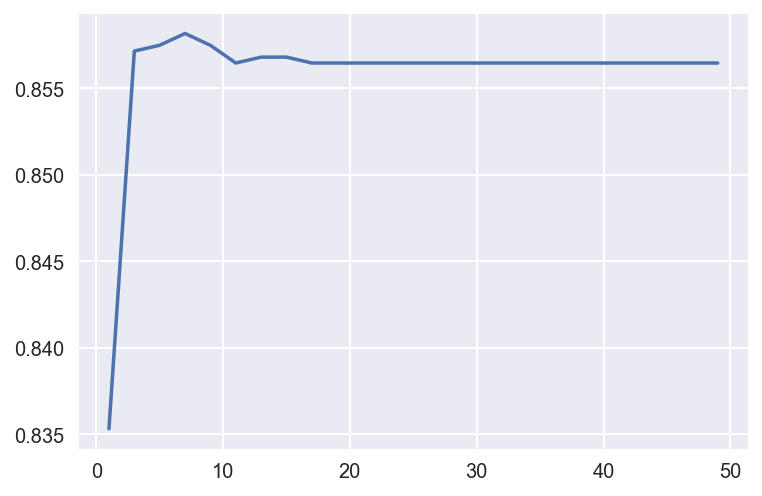

In [25]:
plt.plot(range(1,50,2), score_list)

In [26]:
# based on graph, looks like when k = 29, scores are the highest. Can find out in pd
df = pd.DataFrame([range(1,50,2), score_list]).T
df[df[1] == df[1].max()]

,0,1
3,7.0,0.85817


### 10. Imputing with KNN

K-Nearest Neighbors can be used to impute missing values in datasets. What we will do is estimate the most likely value for the missing data based on a KNN model.

We have two columns with missing data:
- `vmail_plan`
- `vmail_message`

**10.A Create two subsets of the churn dataset: one without missing values for `vmail_plan` and `vmail_message`, and one with only the missing values.**

In [113]:
# A:
churn_nona

subset = churn[churn.vmail_plan.isnull()]

First we will impute values for `vmail_plan`. This is a categorical column and so we will impute using classification (predicting whether the plan is yes or no, 1 vs. 0).

**10.B Create a target that is `vmail_plan` and predictor matrix that is all columns except `state`, `area_code`, `churn`, `vmail_plan`, and `vmail_message`.**

> **Note:** We don't include the `churn` variable in the model to impute. Why? We are imputing these missing values so that we can use the rows to predict churn with more data afterwards. If we imputed with churn as a predictor then we would be cheating.

In [114]:
# A: Find vmail_plan
predictors = [c for c in churn_nona.columns if c not in ['area_code', 'state', 'churn', 
                                                         'vmail_plan', 'vmail_message']]

X = churn_nona[predictors]
y_vmp = churn_nona.vmail_plan

**10.C Standardize the predictor matrix.**

In [115]:
# A:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
Xs = ss.fit_transform(X)

**10.D Find the best K for predicting `vmail_plan`.**

You may want to write a function for this. What is the accuracy for predicting `vmail_plan` at the best K? What is the baseline accuracy for `vmail_plan`?

In [116]:
# A:
def vmail_pred(func, neighborhood, X, y, cv):
    '''neighborhood is a list or range of numbers of neighbors to guess.
    X is the predictor matrix, y is the target, and cv is # of cross-val folds'''
    
    knn_params = {
    'n_neighbors': neighborhood
    }

    gs = GridSearchCV(func, knn_params, cv=cv, verbose=1)
    gs.fit(X, y)
    print gs.best_params_, gs.best_score_
    return gs.predict(X)

In [117]:
neighs = range(1,50,2)    
vmail_pred(KNeighborsClassifier(), neighs, Xs, y_vmp, 10)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


KeyboardInterrupt: 

In [34]:
baseline = 1 - churn.vmail_plan.mean()
print baseline

0.72621888851


**10.E Fit a `KNeighborsClassifier` with the best number of neighbors.**

In [118]:
# A:
knn2 = KNeighborsClassifier(n_neighbors=29)
knn2.fit(Xs,y_vmp)
print np.mean(cross_val_score(knn2, Xs, y_vmp, cv=10))

0.726220658912


**10.F Predict the missing `vmail_plan` values using the subset of the data where it is misssing.**

You will need to:
1. Create a new predictor matrix using the same predictors but from the missing subset of data.
- Standardize this predictor matrix *using the StandardScaler object fit on the non-missing data*. This means you will just use the `.transform()` function. It is important to standardize the new predictors the same way we standardized the original predictors if we want the predictions to make sense.
- Predict what the missing vmail plan values should be.
- Replace the missing values in the original with the predicted values.

> **Note:** It may predict all 0's. This is OK. If you want to see the predicted probabilities of `vmail_plan` for each row you can use the `.predict_proba()` function instead of `.predict()`

In [119]:
# A:
# Make a new predictor matrix of where vmail is NaN
X_new = subset[predictors]

# standardize the predictor matrix using ONLY transform
Xs_new = ss.transform(X_new)

# Getting prediction based on knn2 of vmail_plan
preds = knn2.predict(Xs_new)
y_pp = knn2.predict_proba(Xs_new)

# Reassigning values of vmail_plan to predictions
# subset.vmail_plan = preds

In [66]:
subset.head()

,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
6,MA,121,510,0,0.0,NaN,218.2,88,37.09,348.5,...,0,0,0,0,0,0,0,0,0,0
8,LA,117,408,0,0.0,NaN,184.5,97,31.37,351.6,...,0,0,0,0,0,0,0,0,0,0
15,NY,161,415,0,0.0,NaN,332.9,67,56.59,317.8,...,0,0,0,0,0,0,0,0,0,0
21,CO,77,408,0,0.0,NaN,62.4,89,10.61,169.9,...,0,0,0,0,0,0,0,0,0,0
22,AZ,130,415,0,0.0,NaN,183.0,112,31.11,72.9,...,0,0,0,0,0,0,0,0,0,0


In [65]:
churn_nona.vmail_message.describe()

count    2933.000000
mean        8.022503
std        13.657855
min         0.000000
25%         0.000000
50%         0.000000
75%        19.000000
max        51.000000
Name: vmail_message, dtype: float64

### 11. Impute the missing values for `vmail_message` using the same process.

Since `vmail_message` is essentially a continuous measure, you need to use `KNeighborsRegressor` instead of the `KNeighborsClassifier`.

KNN can do both regression and classification! Instead of "voting" on the class like in classification, the neighbors will average their value for the target in regression.

In [120]:
churn_copy = churn.copy()

# saving the predictions into vmail_plan
churn_copy.ix[subset.index.values,'vmail_plan'] = preds

In [121]:
# A:
# make a standardized predictor matrix. Which we already did earlier
X = churn_nona[predictors] # predictor matrix without subset data + other columns
ss = StandardScaler()
Xs = ss.fit_transform(X)

# make a target variable
y_vmm = churn_nona.vmail_message

In [122]:
from sklearn.neighbors import KNeighborsRegressor

neighs = range(1,50,2)    
preds2 = vmail_pred(KNeighborsRegressor(), neighs, Xs, y_vmm, 10)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


KeyboardInterrupt: 

In [85]:
knr = KNeighborsRegressor(n_neighbors=47)
knr.fit(Xs, y_vmm)
knr.score(Xs, y_vmm)

0.013441492219096407

In [87]:
# Make a new predictor matrix of where vmail is NaN
X_new = subset[predictors]

# standardize the predictor matrix using ONLY transform
Xs_new = ss.transform(X_new)

# Getting prediction based on knr of vmail_message
mess_preds = knr.predict(Xs_new)

# Reassigning values of vmail_message to predictions
subset.vmail_message = mess_preds

In [88]:
# Make a new predictor matrix that's standardized, which we did already.
Xs_new

# Getting prediction based on knr of vmail_message
preds2 = knr.predict(Xs_new)

# Reassigning values of vmail_plan to predictions
subset.vmail_message = preds

# saving the predictions into vmail_plan
churn_copy.ix[subset.index.values,'vmail_message'] = preds2

### 12. Given the accuracy (and $R^2$) of your best imputation models when finding the best K neighbors, do you think imputing is a good idea?

In [ ]:
# A:
# It can or cannot. For R2 for the vmail_plan, the value was better than our baseline.
# However, for vmail_message, the R2 was very bad, mainly because of the huge concentration of 0's.
# I think it would be a case-by-case scenario.

### 13. With the imputed dataset, cross-validate the accuracy predicting churn. Is it better? Worse? The same?

In [93]:
# A:
X = churn_copy[[c for c in churn_nona.columns if not c in ['area_code', 'state', 'churn']]]
y = churn_copy.churn

ss = StandardScaler()
Xs = ss.fit_transform(X)

score_list = []
for i in range(1, 50, 2):
    knn = KNeighborsClassifier(n_neighbors=i)
    score_list.append(np.mean(cross_val_score(knn, Xs, y, cv=10)))

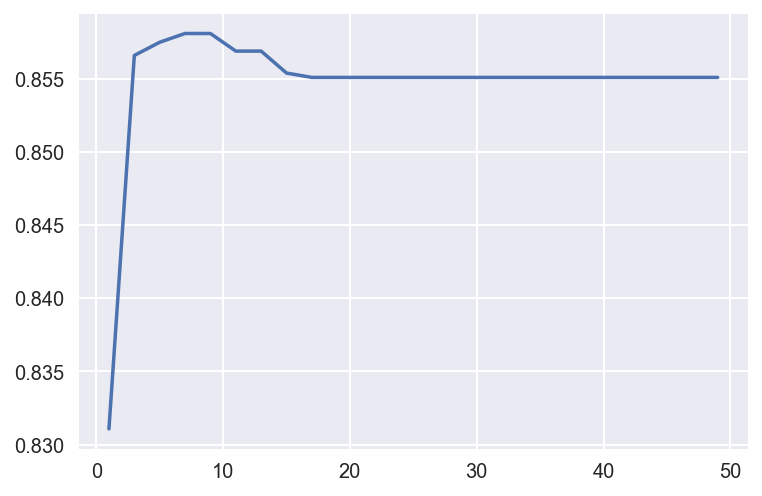

In [95]:
plt.plot(range(1,50,2), score_list)

In [96]:
max(score_list)

0.85808922695150225